In [28]:

import os
import pickle
from copy import deepcopy
from datetime import datetime
from os import listdir

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import yaml
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

In [29]:
# MAIN_DIR = '\\'.join(os.getcwd().split('\\')[:-1])
# RAW_DATA_DIR = MAIN_DIR+'\\data\\raw\\store_item\\'
# PROCESSED_DATA_DIR = MAIN_DIR+'\\data\\processed\\'
# MODEL_DIR = MAIN_DIR + '\\models\\'
# OBJECTS_DIR = MAIN_DIR + '\\objects\\'
# CONFIGS_PATH = MAIN_DIR + '\\configs\\config.yaml'
# SCALER_FILE = 'scaler_info.save'
# TRAIN_PATH = RAW_DATA_DIR + 'train.csv'
# TEST_PATH = RAW_DATA_DIR + 'test.csv'
# PROCESSED_PATH = PROCESSED_DATA_DIR + 'data.csv'
# GROUPED_COLS = ['item','store','date']
# LABEL_COL = 'sales'
# INDEX_COL = 'date'
# NP_ARRAYS_NAMES = ['X_train_series', 'Y_train', 'X_valid_series', 'Y_valid']
#
# LSTM_PARAMS = {
#     'LSTM_WINDOW_LENGTH':29,
#     'LSTM_PREDICTION_LAG':90,
#     'LSTM_NODES':30,
#     'LSTM_EPOCHS':10,
#     'LSTM_BATCH':256,
#     'LSTM_LR':0.003
# }
#
# XGB_PARAMS = {
#     'XGB_MAX_DEPTH':3,
#     'XGB_ETA':0.2,
#     'XGB_SILENT':1,
#     'XGB_SUBSAMPLE':1,
#     'XGB_NUM_ROUNDS':1000
# }
#
# plt.rcParams["figure.figsize"] = [16,9]

In [64]:
MAIN_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])
RAW_DATA_DIR = os.path.join(MAIN_DIR, 'data', 'raw', 'store_item', '')
PROCESSED_DATA_DIR = os.path.join(MAIN_DIR, 'data','processed', '')
MODEL_DIR = os.path.join(MAIN_DIR, 'models', '')
OBJECTS_DIR = os.path.join(MAIN_DIR, 'objects', '')
CONFIGS_PATH = os.path.join(MAIN_DIR, 'configs', 'config.yaml')

SCALER_FILE = 'scaler_info.save'
TRAIN_PATH = RAW_DATA_DIR + 'train.csv'
TEST_PATH = RAW_DATA_DIR + 'test.csv'
PROCESSED_PATH = PROCESSED_DATA_DIR + 'data.csv'

NP_ARRAYS_NAMES = ['X_train_series', 'Y_train', 'X_valid_series', 'Y_valid']

plt.rcParams["figure.figsize"] = [16,9]

In [32]:
# MAIN_DIR = '/'.join(os.getcwd().split('/')[:-1])
# # MAIN_DIR = os.getcwd()
# RAW_DATA_DIR = MAIN_DIR+'/data/raw/store_item/'
# PROCESSED_DATA_DIR = MAIN_DIR+'/data/processed/'
# MODEL_DIR = MAIN_DIR + '/models/'
# OBJECTS_DIR = MAIN_DIR + '/objects/'
# CONFIGS_PATH = MAIN_DIR + '/configs/config.yaml'
# SCALER_FILE = 'scaler_info.save'
# TRAIN_PATH = RAW_DATA_DIR + 'train.csv'
# TEST_PATH = RAW_DATA_DIR + 'test.csv'
# PROCESSED_PATH = PROCESSED_DATA_DIR + 'data.csv'
# GROUPED_COLS = ['item','store','date']
# LABEL_COL = 'sales'
# INDEX_COL = 'date'
# NP_ARRAYS_NAMES = ['X_train_series', 'Y_train', 'X_valid_series', 'Y_valid']
# # %matplotlib inline
# LSTM_PARAMS = {
#     'LSTM_WINDOW_LENGTH':29,
#     'LSTM_PREDICTION_LAG':90,
#     'LSTM_NODES':30,
#     'LSTM_EPOCHS':10,
#     'LSTM_BATCH':256,
#     'LSTM_LR':0.003
# }
#
# XGB_PARAMS = {
#     'XGB_MAX_DEPTH':3,
#     'XGB_ETA':0.2,
#     'XGB_SILENT':1,
#     'XGB_SUBSAMPLE':1,
#     'XGB_NUM_ROUNDS':1000
# }

In [33]:
def get_conf(conf_path):
    with open(rf'{conf_path}') as conf_file:
        conf = yaml.safe_load(conf_file)
        return conf

In [34]:
conf = get_conf(CONFIGS_PATH)


In [35]:
def SMAPE(forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    if len(actual.shape)!=2:
        actual = actual.reshape(actual.shape[0],1)
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2

    smape_score = str(round(sum(diff/avg)/len(forecast) * 100, 2))

    print('SMAPE Error Score: ' + smape_score + ' %')
    return smape_score

In [36]:
def plot_pred_vs_act(actual, predicted, model_type):
    plt.rcParams["figure.figsize"] = [16,9]
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.title(f'Predicted vs Actual Sales for {model_type} Model')

In [37]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [66]:
def xboost(xgb_params, xgb_model_dir, x_train=None, y_train=None, x_test=None, y_test=None, training_req=1):
    """Trains xgboost model and returns it"""

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    file_name = f'xgb_model_{folder_name}.pkl'

    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, label=y_test, feature_names=list(x_test.columns))

    if training_req:

        params = {'max_depth':xgb_params['XGB_MAX_DEPTH'],
                  'eta':xgb_params['XGB_ETA'],
                  'silent':xgb_params['XGB_SILENT'],
                'subsample':xgb_params['XGB_SUBSAMPLE']}
        num_rounds = xgb_params['XGB_NUM_ROUNDS']

        xgb_model = xgb.train(params, dtrain, num_rounds)

        # save
        xgb_model.save_model(xgb_model_dir+file_name)
        # pickle.dump(xgb_model, open(xgb_model_dir+file_name, "wb"))

    else:
        sorted_xgb_models = [x for x in listdir(xgb_model_dir) if 'xgb_' in str(x)]
        sorted_xgb_models.sort(reverse=True)
        xgb_model = xgb.Booster()
        xgb_model.load_model(xgb_model_dir+str(sorted_xgb_models[0]))
        # xgb_model = pickle.load(open(xgb_model_dir+str(sorted_xgb_models[0]), 'rb'))


    return xgb_model, dtest

In [39]:
def lstm_model(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=2)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='rmse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return model_lstm


In [40]:
def read_data(path, date_index_col):
    if path:
        df = pd.read_csv(path, index_col=date_index_col, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index)
        return df

In [41]:
# Prepare data by aggregating according to config
def data_preprocessing(data, grouped_cols, label_col, date_col='date'):
    # Rearrange dataset so we can apply shift methods
    data = data.reset_index()
    data = data.sort_values(date_col).groupby(grouped_cols, as_index=False)
    data = data.agg({f'{label_col}':['mean']})
    data.columns = grouped_cols + [label_col]
    return data


In [42]:
def xgboost_data_preprocessing(data,date_col):

    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col])
    data['year'] = data[date_col].dt.year
    data['quarter'] = data[date_col].dt.quarter
    data['month'] = data[date_col].dt.month
    data['weekofyear'] = data[date_col].dt.weekofyear
    data['weekday'] = data[date_col].dt.weekday
    data['dayofweek'] = data[date_col].dt.dayofweek


    return data

In [43]:
def series_to_supervised(data_in, window=1, lag=1, dropnan=True):
    """Transform the data into a time series problem"""

    data = deepcopy(data_in)
    # Drop date column from data
    data.drop('date', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    # Drop rows with different item or store values than the shifted columns

    last_item = 'item(t-%d)' % window
    last_store = 'store(t-%d)' % window
    agg = agg[(agg['store(t)'] == agg[last_store])]
    agg = agg[(agg['item(t)'] == agg[last_item])]

    columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
    for i in range(window, 0, -1):
        columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
    agg.drop(columns_to_drop, axis=1, inplace=True)
    agg.drop(['item(t)', 'store(t)'], axis=1, inplace=True)
    print(type(agg))

    return agg


In [44]:
def split_train_valid(data, test_size, lag):

    # Label
    labels_col = 'sales(t+%d)' % lag
    labels = data[labels_col]
    data = data.drop(labels_col, axis=1)

    X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels.values, test_size=test_size, random_state=0)

    return X_train, Y_train, X_valid, Y_valid

In [45]:
def reshape_features(X_train,X_valid):
    X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
    return X_train_series, X_valid_series

In [46]:
def data_scaler(data, scaled, model=None):
    if scaled:
        fitted_scaler = joblib.load(OBJECTS_DIR+model+SCALER_FILE)

        if type=='inverse':
            inv_scaled_data = fitted_scaler.inverse_transform(data)
            return inv_scaled_data
        else:
            scaled_data = fitted_scaler.transform(data)
            return scaled_data

    else:
        scaler = StandardScaler()
        fitted_scaler = scaler.fit(data)
        scaled_data = fitted_scaler.transform(data)
        joblib.dump(fitted_scaler, OBJECTS_DIR+model+SCALER_FILE)
        return scaled_data


In [47]:
# Read Training and Testing data
train = read_data(TRAIN_PATH, 0)
test = read_data(TEST_PATH, 1)


<h1> LSTM </h1>

In [48]:
# Prepare train data for lstm by aggregating
preprocessed_data = data_preprocessing(train,
                                       conf['GROUPED_COLS'],
                                       conf['LABEL_COL'],
                                       conf['INDEX_COL']
                                       )

lstm_processed_data_2 = series_to_supervised(preprocessed_data,
                                             window=conf['LSTM_PARAMS']['LSTM_WINDOW_LENGTH'],
                                             lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                             )

# Split into train-test set
X_train, Y_train, X_valid, Y_valid = split_train_valid(lstm_processed_data_2,
                                                       test_size=0.2,
                                                       lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                                       )

# Scale data for training
X_train_scaled = data_scaler(X_train, scaled=0, model='lstm')
X_valid_scaled = data_scaler(X_valid, scaled=1, model='lstm')

# Reshape data for training
X_train_series, X_valid_series = reshape_features(X_train, X_valid)


<class 'pandas.core.frame.DataFrame'>


In [49]:
# Obtain trained LSTM model
model_lstm = lstm_model(conf['LSTM_PARAMS'],
                        MODEL_DIR,
                        X_train_series,
                        Y_train,
                        X_valid_series,
                        Y_valid,
                        training_req=0
                        )


In [50]:
# LSTM Evaluation
lstm_pred = model_lstm.predict(X_valid_series)
lstm_smape = SMAPE(lstm_pred, Y_valid)

SMAPE Error Score: 27.98 %


In [51]:
lstm_mse = model_lstm.evaluate(X_valid_series, Y_valid)

5616/5616 [==============================] - 22s 4ms/step - loss: 316.2183


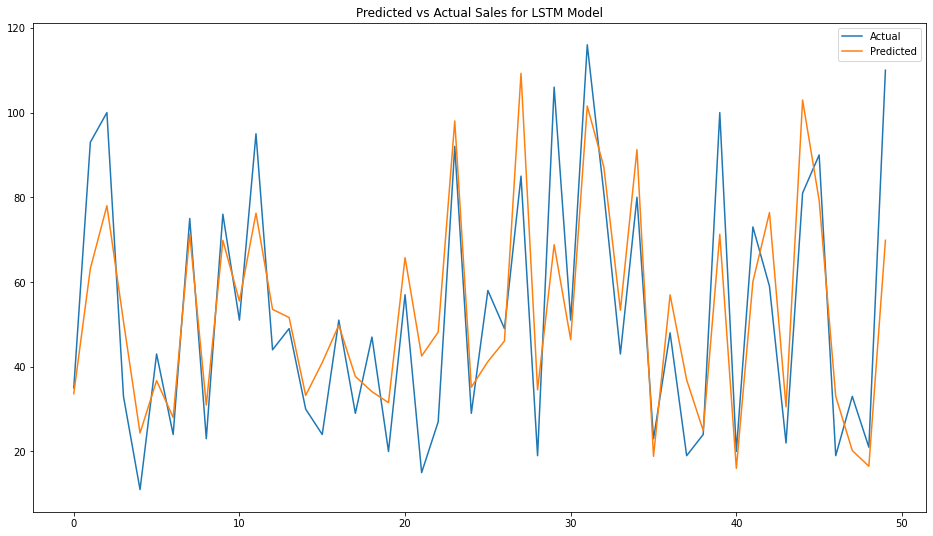

In [65]:
plot_pred_vs_act(Y_valid[:50],lstm_pred[:50],'LSTM')

<h1> XGBoost </h1>

In [53]:
xgb_data = xgboost_data_preprocessing(preprocessed_data, conf['INDEX_COL'])

# Preprocess data to perform aggregation
xgb_train_x, xgb_test_x, xgb_train_y, xgb_test_y = train_test_split(
    xgb_data.drop([f'{conf["INDEX_COL"]}', f'{conf["LABEL_COL"]}'],axis=1),
    xgb_data[conf["LABEL_COL"]],
    test_size=0.2
)

C:\Users\yashc\AppData\Local\Temp\ipykernel_19628\405869160.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['weekofyear'] = data[date_col].dt.weekofyear


In [67]:
# Train XGBoost model
xgb_model, xgb_test_data = xboost(conf['XGB_PARAMS'],
                                  MODEL_DIR,
                                  xgb_train_x,
                                  xgb_train_y,
                                  xgb_test_x,
                                  xgb_test_y,
                                  training_req=1
                                  )


[11:36:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [60]:
# Get predictions from XGBoost model
xgb_predictions = pd.Series(xgb_model.predict(xgb_test_data))

# Transform predictions and actual data for SMAPE
xgb_predictions_reshaped = np.array(xgb_predictions).reshape(len(xgb_predictions),1)
xgb_test_y_reshaped = np.array(xgb_test_y).reshape(len(xgb_test_y),1)

# Get SMAPE for XGBoost
xgb_smape = SMAPE(xgb_predictions_reshaped, xgb_test_y_reshaped)

SMAPE Error Score: 15.4 %


In [61]:
# MSE Computation
xgb_mse = MSE(xgb_test_y_reshaped, xgb_predictions_reshaped)

<h1> Comparing the models' metrics </h1>

In [63]:
print(f'XGB SMAPE- {xgb_smape}%')
print(f'LSTM SMAPE- {lstm_smape}%')

print(f'XGB MSE- {xgb_mse:.2f}')
print(f'LSTM MSE- {lstm_mse:.2f}')

XGB SMAPE- 15.4%
LSTM SMAPE- 27.98%
XGB MSE- 67.91
LSTM MSE- 316.22
